In [500]:
import time
import timeit

import pandas as pd
import numba as nb
import numpy as np

In [4]:
!mkdir dataset

In [5]:
!curl https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip --output dataset/data_original.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 10 75.1M   10 8368k    0     0  6387k      0  0:00:12  0:00:01  0:00:11 6387k
 25 75.1M   25 19.1M    0     0  8505k      0  0:00:09  0:00:02  0:00:07 8505k
 40 75.1M   40 30.7M    0     0  9502k      0  0:00:08  0:00:03  0:00:05 9502k
 55 75.1M   55 41.9M    0     0  9976k      0  0:00:07  0:00:04  0:00:03 9976k
 70 75.1M   70 53.0M    0     0   9.9M      0  0:00:07  0:00:05  0:00:02 11.0M
 85 75.1M   85 64.5M    0     0  10.2M      0  0:00:07  0:00:06  0:00:01 11.2M
100 75.1M  100 75.1M    0     0  10.3M      0  0:00:07  0:00:07 --:--:-- 11.3M


In [6]:
import zipfile

with zipfile.ZipFile("dataset/data_original.zip", mode="r") as archive:
    archive.extractall("dataset")

In [7]:
!del "dataset\data_original.zip"

In [501]:
users = pd.read_csv('dataset/kion_train/users.csv')
items = pd.read_csv('dataset/kion_train/items.csv')
interactions = pd.read_csv('dataset/kion_train/interactions.csv')

interactions.rename(
    columns={
        'track_id': 'item_id',
        'last_watch_dt': 'datetime',
        'total_dur': 'weight'
    }, 
    inplace=True) 

interactions['datetime'] = pd.to_datetime(interactions['datetime'])

In [502]:
def generate_subsample(users_count: int, top_k: int, data: pd.DataFrame=interactions):
    users = np.random.choice(data['user_id'].unique(), users_count, replace=False)
    df = data[data['user_id'].isin(users)].reset_index(drop=True)
    del df['datetime'], df['weight'], df['watched_pct']
    
    recs = np.random.choice(df['item_id'], size=(users_count, top_k))
    return df, users, recs

In [503]:
def left_join_arrays(target: np.ndarray, users: np.ndarray, recs: np.ndarray):
    ranks = np.full((users.size, recs.shape[1]), range(1, recs.shape[1] + 1))
    np_recs = np.stack((np.repeat(users, recs.shape[1]), recs.ravel(), ranks.ravel()), axis=-1)
    np_merged = []

    for user in users:
        full_target = target[target[:, 0] == user]
        user_reco = np_recs[np_recs[:, 0] == user]
        temp_items = []
        for r in user_reco:
            if r[1] in full_target[:, 1]:
                np_merged.append([r[0], r[1], r[2]])
                temp_items.append(r[1])
        for t in full_target:
            if t[1] not in temp_items:
                np_merged.append([t[0], t[1], np.nan])
    return np.array(np_merged)

In [504]:
def ndcg_naive(target: np.ndarray, users: np.ndarray, recs: np.ndarray, k: int):
    np_merged = left_join_arrays(target, users, recs)
    
    user_rank = np_merged[:, 2]
    user_rank[user_rank == 0] = np.nan
    discounts = np.log(user_rank + 1) / np.log(2)
    user_rank = np.where(user_rank <= k, 1, 0)
    dcg = user_rank / discounts
    dcg[np.isnan(dcg)] = 0
    idcg = (1 / (np.log(np.arange(1, k + 1) + 1) / np.log(2))).sum()
    ndcg = (dcg / idcg)
    
    ndcg = ndcg.reshape((ndcg.shape[0], 1))
    
    target_n = np.column_stack((np_merged, ndcg))
    
    ndcg_arr = []
    for i, user in enumerate(users):
        ndcg_arr.append((target_n[target_n[:, 0] == user][:, 3]).sum())
    return sum(ndcg_arr) / len(users)

In [507]:
@nb.njit(cache=True, parallel=True)
def ndcg_numba(target: np.ndarray, users: np.ndarray, k: int):
    user_rank = target[:, 2]
    user_rank[user_rank == 0] = np.nan
    discounts = np.log(user_rank + 1) / np.log(2)
    user_rank = np.where(user_rank <= k, 1, 0)
    dcg = user_rank / discounts
    dcg[np.isnan(dcg)] = 0
    idcg = (1 / (np.log(np.arange(1, k + 1) + 1) / np.log(2))).sum()
    ndcg = (dcg / idcg)
    
    ndcg = ndcg.reshape((ndcg.shape[0], 1))
    
    target_n = np.column_stack((target, ndcg))
    
    ndcg_arr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user = users[i]
        ndcg_arr[i] = (target_n[target_n[:, 0] == user][:, 3]).sum()
    return sum(ndcg_arr) / len(users)

In [508]:
def ndcg_pandas(df_target: pd.DataFrame, users: np.ndarray, recs: np.ndarray, k: int):
    df_recs = pd.DataFrame({
        'user_id': np.repeat(users, recs.shape[1]),
        'item_id': recs.ravel()
    })
    df_recs['rank'] = df_recs.groupby('user_id').cumcount() + 1
    df_merged = pd.merge(
        df_target,
        df_recs,
        on=['item_id', 'user_id'],
        how="left",
    )
    dcg = (df_merged['rank'] <= k).astype(int) / (np.log(df_merged['rank'] + 1) / np.log(2))
    idcg = (1 / (np.log(np.arange(1, k + 1) + 1) / np.log(2))).sum()
    df_merged['ndcg'] = dcg / idcg
    ndcg = df_merged.groupby('user_id')['ndcg'].sum()
    return ndcg.mean()

In [509]:
users_counts = [100, 1000, 10000, 100000]
top_ks = [10, 50, 100]
n_runs = 10

In [510]:
avg_time_naive = np.zeros((len(users_counts), len(top_ks)))
avg_time_numba = np.zeros((len(users_counts), len(top_ks)))
avg_time_pandas = np.zeros((len(users_counts), len(top_ks)))

In [511]:
for i, user_count in enumerate(users_counts):
    for j, top_k in enumerate(top_ks):
        df, users, recs = generate_subsample(user_count, top_k)
        target = df.values
        
        print(f'Run naive user_count: {user_count}, top_k: {top_k} for {n_runs} times')
        t = timeit.timeit('ndcg_naive(target, users, recs, top_k)', "from __main__ import ndcg_naive, target, users, recs, top_k" , number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        avg_time_naive[i][j] = t / n_runs
              
        print(f'Run numba user_count: {user_count}, top_k: {top_k} for {n_runs} times')
        t = timeit.timeit('ndcg_numba(left_join_arrays(target, users, recs), users, top_k)', "from __main__ import ndcg_numba, left_join_arrays, target, users, recs, top_k", number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        avg_time_numba[i][j] = t / n_runs
               
        print(f'Run pandas user_count: {user_count}, top_k: {top_k} for {n_runs} times')
        t = timeit.timeit('ndcg_pandas(df, users, recs, top_k)', "from __main__ import ndcg_pandas, df, users, recs, top_k", number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        avg_time_pandas[i][j] = t / n_runs

Run naive user_count: 100, top_k: 10 for 10 times
Avg time: 0.0064 seconds
Run numba user_count: 100, top_k: 10 for 10 times
Avg time: 0.3306 seconds
Run pandas user_count: 100, top_k: 10 for 10 times
Avg time: 0.0062 seconds
Run naive user_count: 100, top_k: 50 for 10 times
Avg time: 0.0221 seconds
Run numba user_count: 100, top_k: 50 for 10 times
Avg time: 0.0295 seconds
Run pandas user_count: 100, top_k: 50 for 10 times
Avg time: 0.0065 seconds
Run naive user_count: 100, top_k: 100 for 10 times
Avg time: 0.0402 seconds
Run numba user_count: 100, top_k: 100 for 10 times
Avg time: 0.0558 seconds
Run pandas user_count: 100, top_k: 100 for 10 times
Avg time: 0.0070 seconds
Run naive user_count: 1000, top_k: 10 for 10 times
Avg time: 0.1046 seconds
Run numba user_count: 1000, top_k: 10 for 10 times
Avg time: 0.1097 seconds
Run pandas user_count: 1000, top_k: 10 for 10 times
Avg time: 0.0084 seconds
Run naive user_count: 1000, top_k: 50 for 10 times
Avg time: 0.3276 seconds
Run numba user

KeyboardInterrupt: 

C:\Users\shubnyi\AppData\Local\Temp\ipykernel_12180\2081598224.py:16: RuntimeWarning: divide by zero encountered in log
  ax[1][i].plot(users_counts, np.log(avg_time_naive[:, i]), label='Naive')
C:\Users\shubnyi\AppData\Local\Temp\ipykernel_12180\2081598224.py:17: RuntimeWarning: divide by zero encountered in log
  ax[1][i].plot(users_counts, np.log(avg_time_numba[:, i]), label='Numba')
C:\Users\shubnyi\AppData\Local\Temp\ipykernel_12180\2081598224.py:18: RuntimeWarning: divide by zero encountered in log
  ax[1][i].plot(users_counts, np.log(avg_time_pandas[:, i]), label='Pandas')


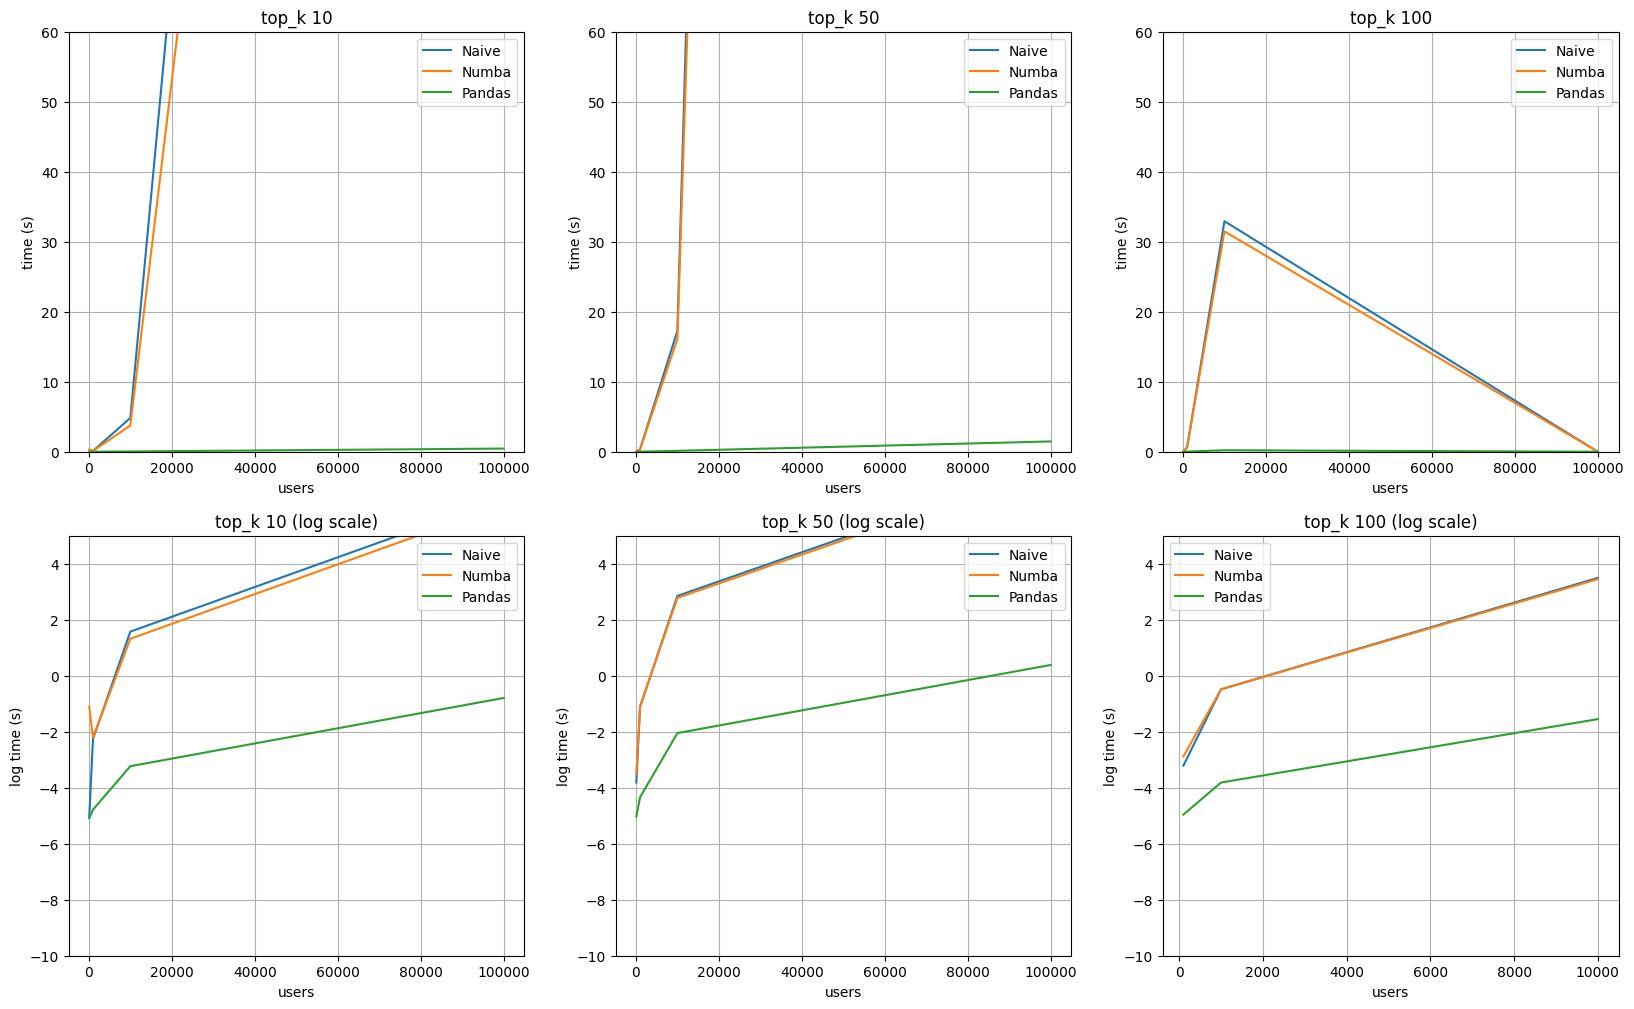

In [514]:
from matplotlib import pyplot as plt

_, ax = plt.subplots(2, 3, figsize=(20, 12))
for i in range(3):
    ax[0][i].plot(users_counts, avg_time_naive[:, i], label='Naive')
    ax[0][i].plot(users_counts, avg_time_numba[:, i], label='Numba')
    ax[0][i].plot(users_counts, avg_time_pandas[:, i], label='Pandas')
    ax[0][i].set_title(f'top_k {top_ks[i]}')
    ax[0][i].set_xlabel('users')
    ax[0][i].set_ylabel('time (s)')
    ax[0][i].set_ylim(0, 60)
    ax[0][i].grid()
    ax[0][i].legend()
    
    # log scale
    ax[1][i].plot(users_counts, np.log(avg_time_naive[:, i]), label='Naive')
    ax[1][i].plot(users_counts, np.log(avg_time_numba[:, i]), label='Numba')
    ax[1][i].plot(users_counts, np.log(avg_time_pandas[:, i]), label='Pandas')
    ax[1][i].set_title(f'top_k {top_ks[i]} (log scale)')
    ax[1][i].set_xlabel('users')
    ax[1][i].set_ylabel('log time (s)')
    ax[1][i].set_ylim(-10, 5)
    ax[1][i].grid()
    ax[1][i].legend()
plt.show()

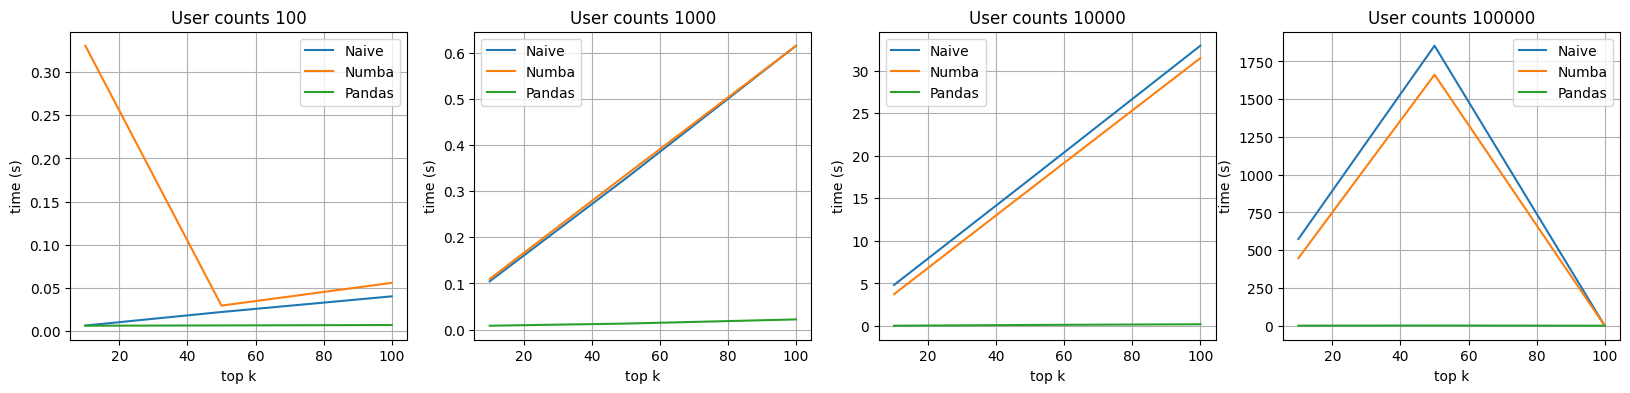

In [515]:
_, ax = plt.subplots(1, 4, figsize=(20, 4))
for i in range(4):
    ax[i].plot(top_ks, avg_time_naive[i, :], label='Naive')
    ax[i].plot(top_ks, avg_time_numba[i, :], label='Numba')
    ax[i].plot(top_ks, avg_time_pandas[i, :], label='Pandas')
    ax[i].set_title(f'User counts {users_counts[i]}')
    ax[i].grid()
    ax[i].set_xlabel('top k')
    ax[i].set_ylabel('time (s)')
    ax[i].legend()
plt.show()